In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set plotting styles
sns.set(style="whitegrid")

# Ensure plots are displayed in the notebook
%matplotlib inline


In [2]:
file_path = '../data/Unemployment_Rate_upto_11_2020.xlsx'
unemployment_data = pd.read_excel(file_path)

# Display basic information about the dataset
print(unemployment_data.info())
print(unemployment_data.describe())

# Convert Date column to datetime
unemployment_data['Date'] = pd.to_datetime(unemployment_data['Date'], format='%d-%m-%Y')

# Drop redundant column
unemployment_data = unemployment_data.drop(columns=['Region.1'])

# Check for missing values
print(unemployment_data.isnull().sum())

# Display first few rows of the cleaned dataframe
print(unemployment_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Region                                   267 non-null    object 
 1   Date                                     267 non-null    object 
 2   Frequency                                267 non-null    object 
 3   Estimated Unemployment Rate (%)          267 non-null    float64
 4   Estimated Employed                       267 non-null    int64  
 5   Estimated Labour Participation Rate (%)  267 non-null    float64
 6   Region.1                                 267 non-null    object 
 7   Longitude                                267 non-null    float64
 8   Latitude                                 267 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 18.9+ KB
None
       Estimated Unemployment Rate (%)  Estimated Employed

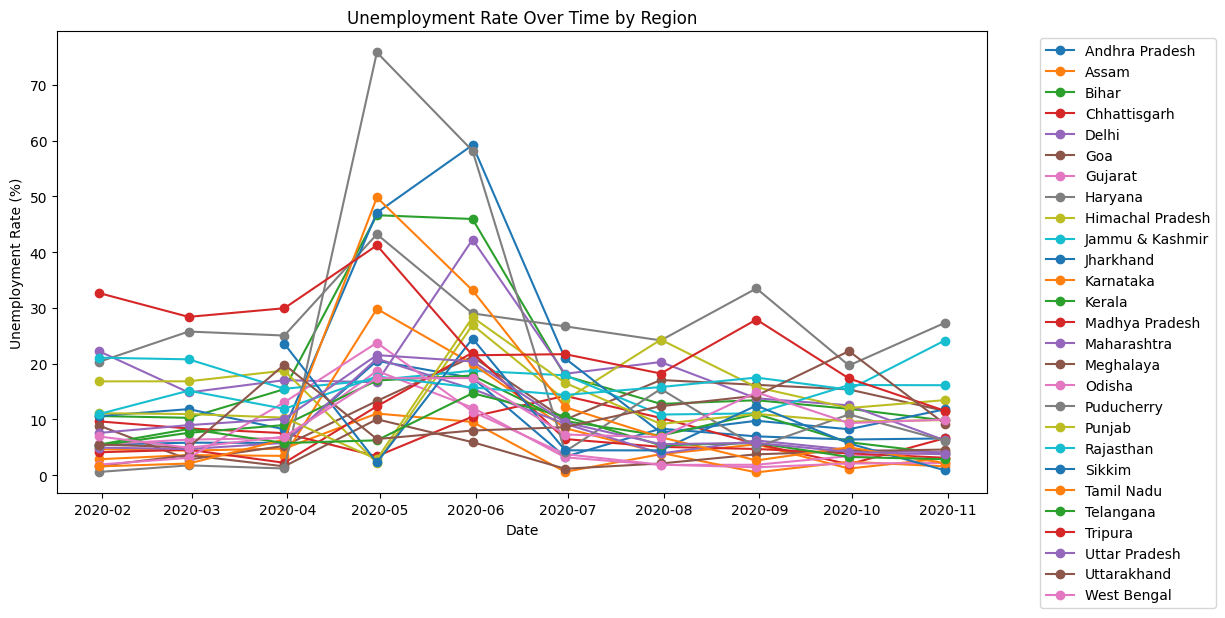

In [5]:
# Line plot of unemployment rate over time
plt.figure(figsize=(12, 6))
for region in unemployment_data['Region'].unique():
    region_data = unemployment_data[unemployment_data['Region'] == region]
    plt.plot(region_data['Date'], region_data['Estimated Unemployment Rate (%)'], marker='o', label=region)

plt.title('Unemployment Rate Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


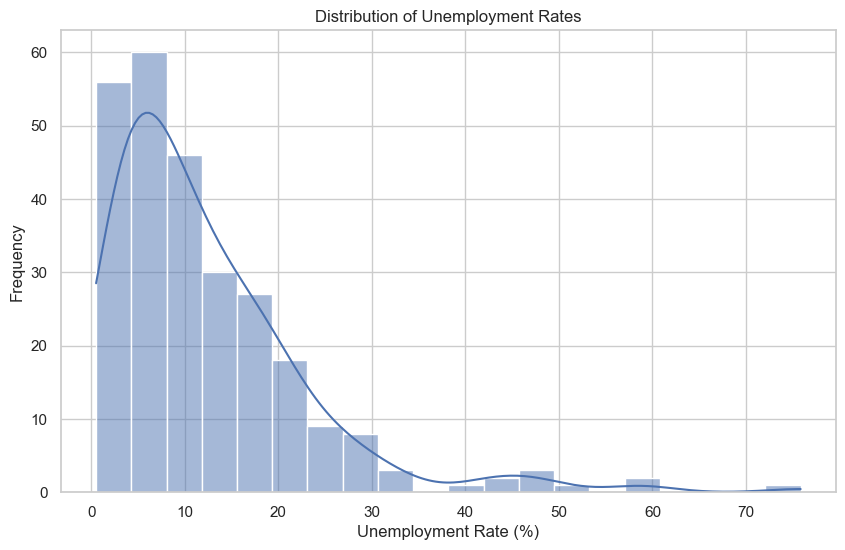

In [4]:
# Histogram of unemployment rates
plt.figure(figsize=(10, 6))
sns.histplot(unemployment_data['Estimated Unemployment Rate (%)'], bins=20, kde=True)
plt.title('Distribution of Unemployment Rates')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.show()


Training size: 8
Testing size: 2


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\AppData\Local\Temp\ipykernel_1

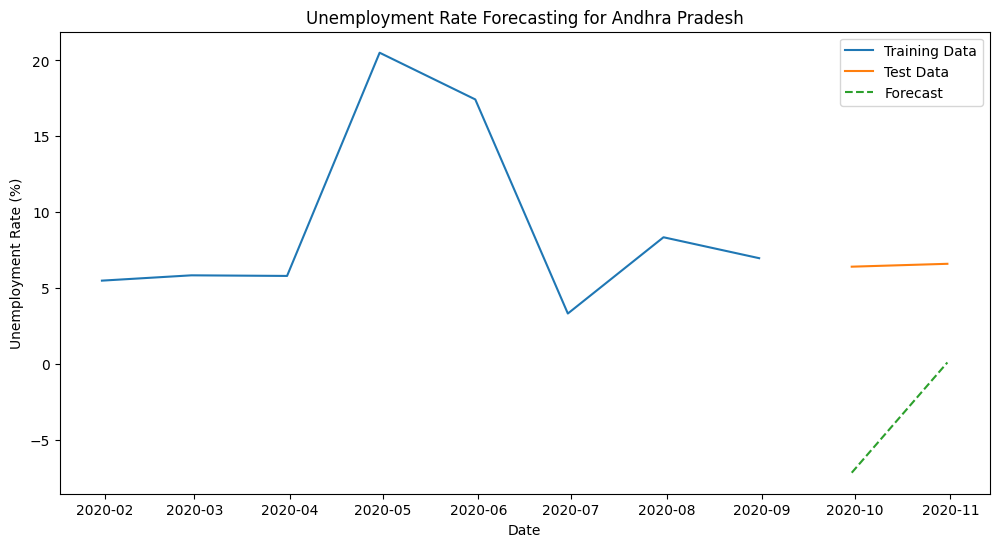

Mean Squared Error: 113.4839587230374


In [7]:
# Select a region for forecasting
region = 'Andhra Pradesh'
region_data = unemployment_data[unemployment_data['Region'] == region].copy()

# Set Date as the index
region_data.set_index('Date', inplace=True)

# Train-test split
train_size = int(len(region_data) * 0.8)
train, test = region_data.iloc[:train_size], region_data.iloc[train_size:]

print(f'Training size: {len(train)}')
print(f'Testing size: {len(test)}')

# Fit ARIMA model
model = ARIMA(train['Estimated Unemployment Rate (%)'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))
test['Forecast'] = forecast

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Estimated Unemployment Rate (%)'], label='Training Data')
plt.plot(test.index, test['Estimated Unemployment Rate (%)'], label='Test Data')
plt.plot(test.index, test['Forecast'], label='Forecast', linestyle='--')
plt.title(f'Unemployment Rate Forecasting for {region}')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.show()

# Calculate Mean Squared Error
mse = mean_squared_error(test['Estimated Unemployment Rate (%)'], test['Forecast'])
print(f'Mean Squared Error: {mse}')
